# Project 3: Multi-class Classification with Deep MLP

Classifying Fashion-MNIST images into 10 clothing categories using a deep Multi-Layer Perceptron with regularization techniques.

**Concepts Covered:**
- Multi-class classification with `CrossEntropyLoss`
- `DataLoader` for batched training
- `torchvision` datasets and transforms
- Dropout regularization
- Batch Normalization
- Learning Rate Scheduler (`ReduceLROnPlateau`)
- Early Stopping with best model saving
- Flattening images for MLP input

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

PyTorch version: 2.10.0+cpu
CUDA available: False


---
## Phase 1: Load and Explore Fashion-MNIST

Fashion-MNIST contains 70,000 grayscale images (28x28) of 10 clothing categories.

| Concept | Project 2 (Binary) | Project 3 (Multi-class) |
|---|---|---|
| Output | 1 probability (0-1) | 10 scores (one per class) |
| Activation | Sigmoid | Softmax (built into CrossEntropyLoss) |
| Loss | BCELoss | CrossEntropyLoss |
| Prediction | threshold ≥ 0.5 | torch.max (highest score) |

In [2]:
# Transforms: convert images to tensors and normalize to [-1, 1]
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Download datasets
train_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)

# DataLoader — handles batching and shuffling
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Class names
class_names = ['T-shirt', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

print(f"Train samples: {len(train_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Image shape: {train_dataset[0][0].shape}")
print(f"Number of classes: {len(class_names)}")

100.0%
100.0%
100.0%
100.0%


Train samples: 60000
Test samples: 10000
Image shape: torch.Size([1, 28, 28])
Number of classes: 10


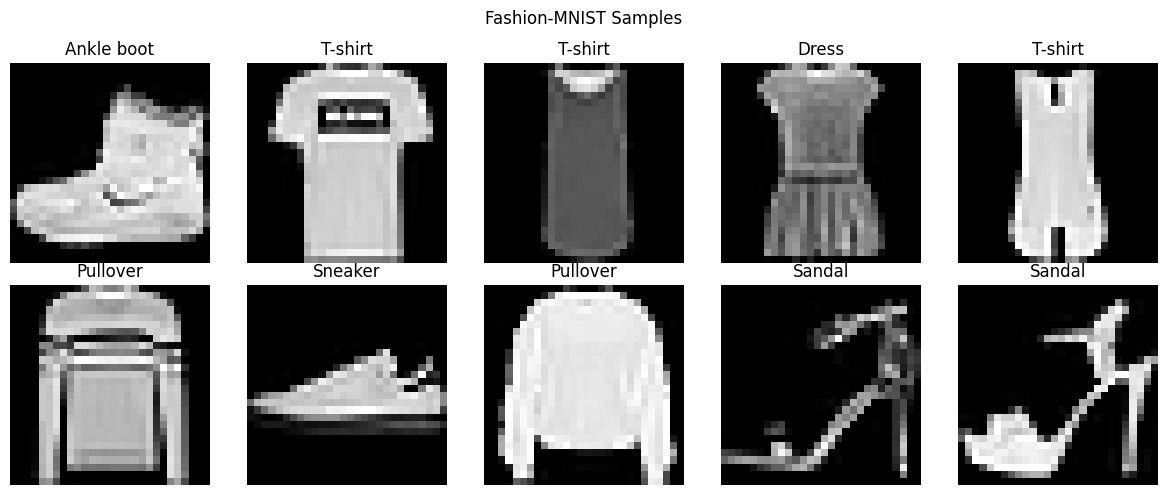

In [3]:
# Visualize sample images
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    image, label = train_dataset[i]
    ax.imshow(image.squeeze(), cmap='gray')
    ax.set_title(class_names[label])
    ax.axis('off')
plt.suptitle("Fashion-MNIST Samples")
plt.tight_layout()
plt.show()

---
## Phase 2: Define Deep MLP with Regularization

New techniques introduced:
- **nn.Flatten()** — converts (1, 28, 28) image to (784,) vector for Linear layers
- **nn.BatchNorm1d()** — normalizes layer outputs for stable training
- **nn.Dropout()** — randomly disables neurons to prevent overfitting
- **No softmax in model** — CrossEntropyLoss handles it internally

In [4]:
class DeepMLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()          # (1, 28, 28) → (784)
        
        self.layer1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256)
        
        self.layer2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        
        self.layer3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        
        self.output = nn.Linear(64, 10)      # 10 classes
        
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.flatten(x)
        
        x = self.relu(self.bn1(self.layer1(x)))
        x = self.dropout(x)
        
        x = self.relu(self.bn2(self.layer2(x)))
        x = self.dropout(x)
        
        x = self.relu(self.bn3(self.layer3(x)))
        x = self.dropout(x)
        
        x = self.output(x)     # no softmax — CrossEntropyLoss handles it
        return x

model = DeepMLP()
print(model)
print(f"\nTotal parameters: {sum(p.numel() for p in model.parameters()):,}")

DeepMLP(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (layer1): Linear(in_features=784, out_features=256, bias=True)
  (bn1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer2): Linear(in_features=256, out_features=128, bias=True)
  (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (layer3): Linear(in_features=128, out_features=64, bias=True)
  (bn3): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (output): Linear(in_features=64, out_features=10, bias=True)
  (relu): ReLU()
  (dropout): Dropout(p=0.3, inplace=False)
)

Total parameters: 243,658


In [5]:
# Loss, optimizer, and scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=5, factor=0.5
)

In [6]:
# Training loop with batches, early stopping, and LR scheduling
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []
best_test_loss = float('inf')
patience_counter = 0
patience_limit = 15

for epoch in range(50):
    # --- Training ---
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for batch_X, batch_y in train_loader:
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * batch_X.size(0)
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    
    train_loss = running_loss / total
    train_acc = correct / total
    
    # --- Evaluation ---
    model.eval()
    running_test_loss = 0.0
    correct_test = 0
    total_test = 0
    
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model(batch_X)
            loss = criterion(outputs, batch_y)
            
            running_test_loss += loss.item() * batch_X.size(0)
            _, predicted = torch.max(outputs, 1)
            total_test += batch_y.size(0)
            correct_test += (predicted == batch_y).sum().item()
    
    test_loss = running_test_loss / total_test
    test_acc = correct_test / total_test
    
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_accuracies.append(train_acc)
    test_accuracies.append(test_acc)
    
    # Learning rate scheduler
    scheduler.step(test_loss)
    
    # Early stopping
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        patience_counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        patience_counter += 1
    
    if epoch % 5 == 0:
        print(f"Epoch {epoch:2d} | Train Loss: {train_loss:.4f} | Test Loss: {test_loss:.4f} | Train Acc: {train_acc:.4f} | Test Acc: {test_acc:.4f}")
    
    if patience_counter >= patience_limit:
        print(f"\nEarly stopping at epoch {epoch}!")
        break

print(f"\nBest Test Loss: {best_test_loss:.4f}")
print(f"Final Test Accuracy: {test_accuracies[-1]:.4f}")

Epoch  0 | Train Loss: 0.6191 | Test Loss: 0.4178 | Train Acc: 0.8004 | Test Acc: 0.8485
Epoch  5 | Train Loss: 0.3523 | Test Loss: 0.3424 | Train Acc: 0.8738 | Test Acc: 0.8720
Epoch 10 | Train Loss: 0.3052 | Test Loss: 0.3092 | Train Acc: 0.8902 | Test Acc: 0.8886
Epoch 15 | Train Loss: 0.2735 | Test Loss: 0.3048 | Train Acc: 0.9001 | Test Acc: 0.8883
Epoch 20 | Train Loss: 0.2530 | Test Loss: 0.2987 | Train Acc: 0.9081 | Test Acc: 0.8939
Epoch 25 | Train Loss: 0.2165 | Test Loss: 0.2966 | Train Acc: 0.9220 | Test Acc: 0.8978
Epoch 30 | Train Loss: 0.2009 | Test Loss: 0.2952 | Train Acc: 0.9265 | Test Acc: 0.9017
Epoch 35 | Train Loss: 0.1875 | Test Loss: 0.2999 | Train Acc: 0.9318 | Test Acc: 0.9006
Epoch 40 | Train Loss: 0.1683 | Test Loss: 0.2987 | Train Acc: 0.9384 | Test Acc: 0.9030
Epoch 45 | Train Loss: 0.1559 | Test Loss: 0.2947 | Train Acc: 0.9435 | Test Acc: 0.9048

Early stopping at epoch 46!

Best Test Loss: 0.2894
Final Test Accuracy: 0.9051


---
## Phase 3: Detailed Evaluation

In [7]:
# Load best model and evaluate
model.load_state_dict(torch.load("best_model.pth"))
model.eval()

all_preds = []
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.numpy())
        all_labels.extend(batch_y.numpy())

print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names=class_names))

Classification Report:
              precision    recall  f1-score   support

     T-shirt       0.84      0.86      0.85      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.81      0.85      0.83      1000
       Dress       0.90      0.91      0.91      1000
        Coat       0.82      0.84      0.83      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.77      0.69      0.73      1000
     Sneaker       0.95      0.96      0.96      1000
         Bag       0.98      0.97      0.98      1000
  Ankle boot       0.97      0.96      0.97      1000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



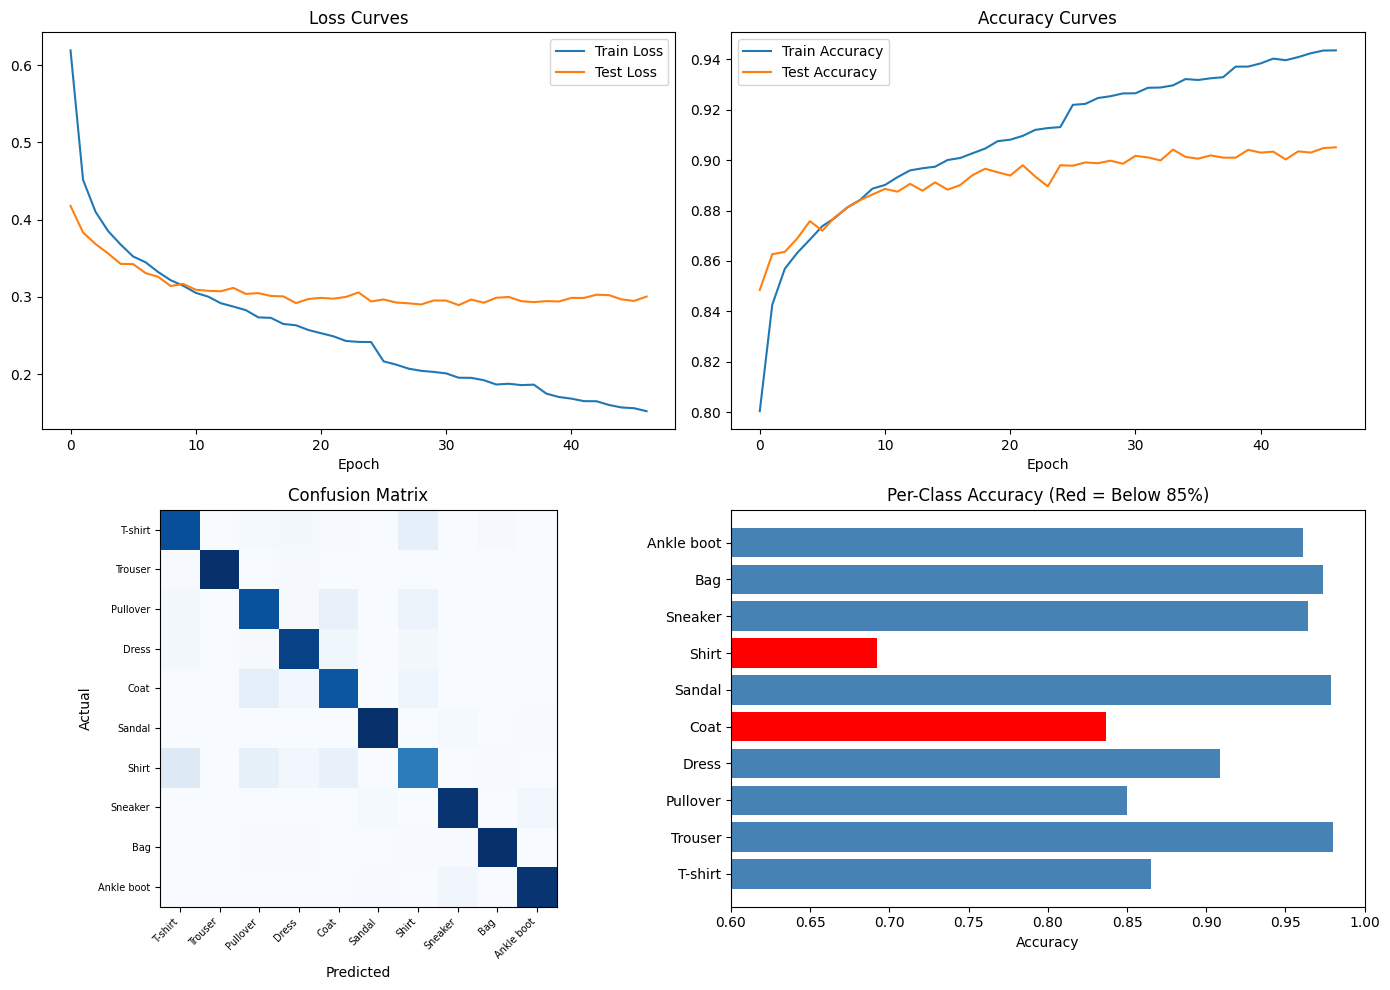

In [8]:
# Comprehensive visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Loss curves
axes[0][0].plot(train_losses, label="Train Loss")
axes[0][0].plot(test_losses, label="Test Loss")
axes[0][0].set_title("Loss Curves")
axes[0][0].set_xlabel("Epoch")
axes[0][0].legend()

# Accuracy curves
axes[0][1].plot(train_accuracies, label="Train Accuracy")
axes[0][1].plot(test_accuracies, label="Test Accuracy")
axes[0][1].set_title("Accuracy Curves")
axes[0][1].set_xlabel("Epoch")
axes[0][1].legend()

# Confusion matrix
cm = confusion_matrix(all_labels, all_preds)
im = axes[1][0].imshow(cm, cmap="Blues")
axes[1][0].set_xticks(range(10))
axes[1][0].set_yticks(range(10))
axes[1][0].set_xticklabels(class_names, rotation=45, ha="right", fontsize=7)
axes[1][0].set_yticklabels(class_names, fontsize=7)
axes[1][0].set_xlabel("Predicted")
axes[1][0].set_ylabel("Actual")
axes[1][0].set_title("Confusion Matrix")

# Per-class accuracy
class_accs = []
for i in range(10):
    class_mask = np.array(all_labels) == i
    class_acc = (np.array(all_preds)[class_mask] == i).mean()
    class_accs.append(class_acc)

colors = ['red' if acc < 0.85 else 'steelblue' for acc in class_accs]
axes[1][1].barh(class_names, class_accs, color=colors)
axes[1][1].set_xlabel("Accuracy")
axes[1][1].set_title("Per-Class Accuracy (Red = Below 85%)")
axes[1][1].set_xlim(0.6, 1.0)

plt.tight_layout()
plt.show()

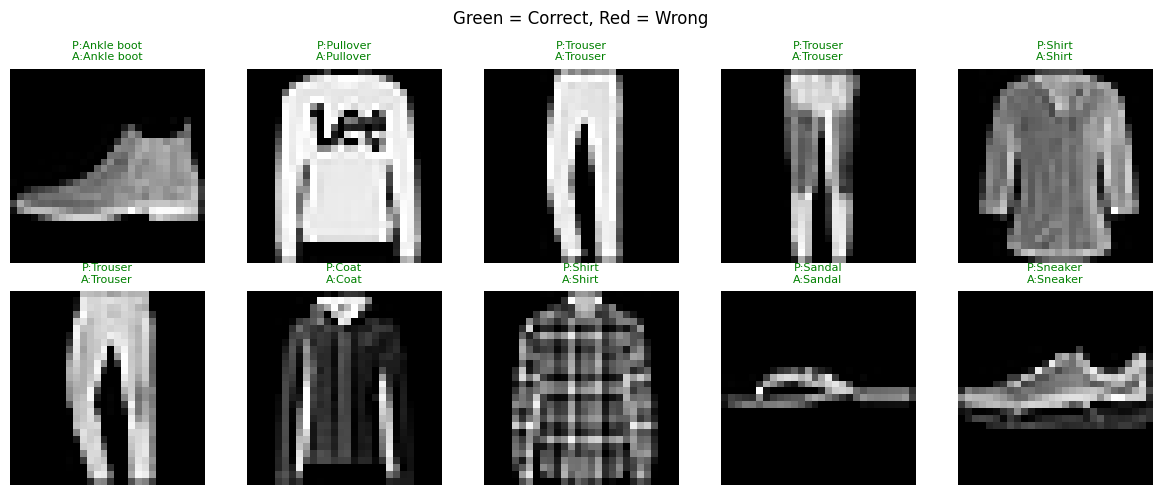

In [9]:
# Sample predictions visualization
fig, axes = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axes.flat):
    image, label = test_dataset[i]
    with torch.no_grad():
        output = model(image.unsqueeze(0))
        _, pred = torch.max(output, 1)
    ax.imshow(image.squeeze(), cmap='gray')
    color = 'green' if pred.item() == label else 'red'
    ax.set_title(f"P:{class_names[pred.item()]}\nA:{class_names[label]}", color=color, fontsize=8)
    ax.axis('off')
plt.suptitle("Green = Correct, Red = Wrong")
plt.tight_layout()
plt.show()

In [10]:
# Per-class accuracy printout
print("Per-Class Accuracy:")
for i, name in enumerate(class_names):
    class_mask = np.array(all_labels) == i
    class_acc = (np.array(all_preds)[class_mask] == i).mean()
    print(f"  {name:12s}: {class_acc:.4f}")

Per-Class Accuracy:
  T-shirt     : 0.8650
  Trouser     : 0.9800
  Pullover    : 0.8500
  Dress       : 0.9090
  Coat        : 0.8370
  Sandal      : 0.9790
  Shirt       : 0.6920
  Sneaker     : 0.9640
  Bag         : 0.9740
  Ankle boot  : 0.9610


---
## Experiment: Impact of Dropout

Training the same model without dropout to observe overfitting.

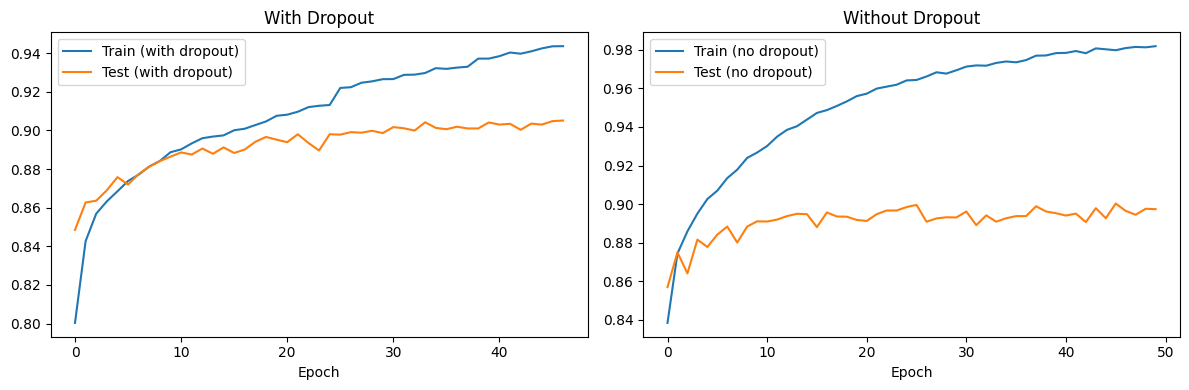

With Dropout    → Train: 0.9436, Test: 0.9051, Gap: 0.0385
Without Dropout → Train: 0.9819, Test: 0.8974, Gap: 0.0845


In [11]:
# Model WITHOUT dropout
class DeepMLP_NoDropout(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(784, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.layer2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.layer3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.output = nn.Linear(64, 10)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.relu(self.bn1(self.layer1(x)))
        x = self.relu(self.bn2(self.layer2(x)))
        x = self.relu(self.bn3(self.layer3(x)))
        x = self.output(x)
        return x

model_nd = DeepMLP_NoDropout()
criterion_nd = nn.CrossEntropyLoss()
optimizer_nd = optim.Adam(model_nd.parameters(), lr=0.001)

nd_train_acc = []
nd_test_acc = []

for epoch in range(50):
    model_nd.train()
    correct = 0
    total = 0
    for batch_X, batch_y in train_loader:
        outputs = model_nd(batch_X)
        loss = criterion_nd(outputs, batch_y)
        optimizer_nd.zero_grad()
        loss.backward()
        optimizer_nd.step()
        _, predicted = torch.max(outputs, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()
    nd_train_acc.append(correct / total)
    
    model_nd.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model_nd(batch_X)
            _, predicted = torch.max(outputs, 1)
            total_test += batch_y.size(0)
            correct_test += (predicted == batch_y).sum().item()
    nd_test_acc.append(correct_test / total_test)

# Compare
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_accuracies, label="Train (with dropout)")
axes[0].plot(test_accuracies, label="Test (with dropout)")
axes[0].set_title("With Dropout")
axes[0].set_xlabel("Epoch")
axes[0].legend()

axes[1].plot(nd_train_acc, label="Train (no dropout)")
axes[1].plot(nd_test_acc, label="Test (no dropout)")
axes[1].set_title("Without Dropout")
axes[1].set_xlabel("Epoch")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"With Dropout    → Train: {train_accuracies[-1]:.4f}, Test: {test_accuracies[-1]:.4f}, Gap: {train_accuracies[-1]-test_accuracies[-1]:.4f}")
print(f"Without Dropout → Train: {nd_train_acc[-1]:.4f}, Test: {nd_test_acc[-1]:.4f}, Gap: {nd_train_acc[-1]-nd_test_acc[-1]:.4f}")

---
## Experiment: Impact of Batch Normalization

Training the same model without BatchNorm to observe effect on training stability and accuracy.

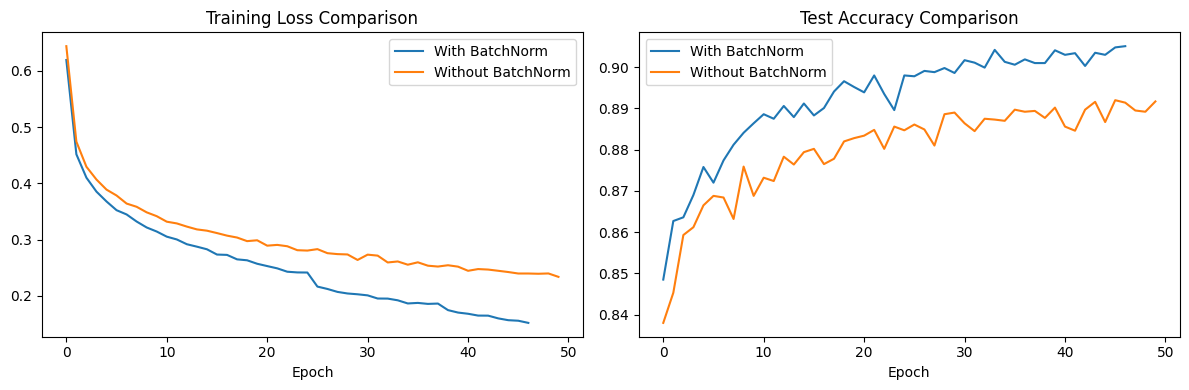

With BatchNorm    → Final Test Acc: 0.9051
Without BatchNorm → Final Test Acc: 0.8917


In [12]:
# Model WITHOUT batch normalization
class DeepMLP_NoBN(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.layer1 = nn.Linear(784, 256)
        self.layer2 = nn.Linear(256, 128)
        self.layer3 = nn.Linear(128, 64)
        self.output = nn.Linear(64, 10)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.3)
    
    def forward(self, x):
        x = self.flatten(x)
        x = self.dropout(self.relu(self.layer1(x)))
        x = self.dropout(self.relu(self.layer2(x)))
        x = self.dropout(self.relu(self.layer3(x)))
        x = self.output(x)
        return x

model_nbn = DeepMLP_NoBN()
criterion_nbn = nn.CrossEntropyLoss()
optimizer_nbn = optim.Adam(model_nbn.parameters(), lr=0.001)

nbn_train_losses = []
nbn_test_acc = []

for epoch in range(50):
    model_nbn.train()
    running_loss = 0.0
    total = 0
    for batch_X, batch_y in train_loader:
        outputs = model_nbn(batch_X)
        loss = criterion_nbn(outputs, batch_y)
        optimizer_nbn.zero_grad()
        loss.backward()
        optimizer_nbn.step()
        running_loss += loss.item() * batch_X.size(0)
        total += batch_y.size(0)
    nbn_train_losses.append(running_loss / total)
    
    model_nbn.eval()
    correct_test = 0
    total_test = 0
    with torch.no_grad():
        for batch_X, batch_y in test_loader:
            outputs = model_nbn(batch_X)
            _, predicted = torch.max(outputs, 1)
            total_test += batch_y.size(0)
            correct_test += (predicted == batch_y).sum().item()
    nbn_test_acc.append(correct_test / total_test)

# Compare
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].plot(train_losses, label="With BatchNorm")
axes[0].plot(nbn_train_losses, label="Without BatchNorm")
axes[0].set_title("Training Loss Comparison")
axes[0].set_xlabel("Epoch")
axes[0].legend()

axes[1].plot(test_accuracies, label="With BatchNorm")
axes[1].plot(nbn_test_acc, label="Without BatchNorm")
axes[1].set_title("Test Accuracy Comparison")
axes[1].set_xlabel("Epoch")
axes[1].legend()

plt.tight_layout()
plt.show()

print(f"With BatchNorm    → Final Test Acc: {test_accuracies[-1]:.4f}")
print(f"Without BatchNorm → Final Test Acc: {nbn_test_acc[-1]:.4f}")

In [13]:
# Save best model
print("Best model saved as best_model.pth")

Best model saved as best_model.pth


---
## Key Takeaways

### Concepts Learned
1. **DataLoader** — batches and shuffles data for memory-efficient training
2. **CrossEntropyLoss** — multi-class loss that includes softmax internally
3. **torch.max(outputs, 1)** — gets predicted class (replaces threshold from binary)
4. **nn.Flatten()** — converts 2D images to 1D vectors for Linear layers (28x28 → 784)
5. **Dropout** — randomly disables neurons during training to prevent overfitting
6. **BatchNorm** — normalizes layer outputs for faster, more stable training
7. **ReduceLROnPlateau** — reduces learning rate when loss stops improving
8. **Early Stopping** — stops training when test loss stops improving, saves best model

### Experimental Findings
- Removing dropout → train/test accuracy gap increases (overfitting)
- Removing BatchNorm → faster per epoch but lower accuracy
- Similar clothing items (Shirt, T-shirt, Pullover, Coat) get confused — MLP limitation

### Test Your Knowledge
- MLP vs CNN — when to use which (MLP for tabular, CNN for images)
- How dropout prevents overfitting (forces neurons to be independently useful)
- How BatchNorm works (normalizes using batch stats in train, running stats in eval)
- Why model.train() and model.eval() matter (controls dropout and BatchNorm behavior)
- Early stopping + best model saving pattern
- DataLoader batching vs full dataset training